In [8]:
# !pip install --upgrade tensorflow

In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
print(np.__version__)

1.19.2


In [4]:
# !pip install tensorflow

In [5]:
pip --version

pip 20.2.4 from /home/gb/anaconda3/lib/python3.8/site-packages/pip (python 3.8)
Note: you may need to restart the kernel to use updated packages.


In [6]:
tf.__version__

'2.5.0'

In [7]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/train'
valid_path = 'Datasets/test'

In [8]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [9]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [10]:
# useful for getting number of output classes
folders = glob('/home/gb/PycharmProjects/Deep_Learning_Car_Brand/Datasets/train/*')

In [11]:
folders

['/home/gb/PycharmProjects/Deep_Learning_Car_Brand/Datasets/train/ferrari',
 '/home/gb/PycharmProjects/Deep_Learning_Car_Brand/Datasets/train/bmw',
 '/home/gb/PycharmProjects/Deep_Learning_Car_Brand/Datasets/train/mercedes']

In [12]:
len(folders)

3

In [13]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)
x =Dense(256, activation='relu')(x)

In [14]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [16]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
train='/home/gb/PycharmProjects/Deep_Learning_Car_Brand/Datasets/train'

#Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 73 images belonging to 3 classes.


In [18]:
test='/home/gb/PycharmProjects/Deep_Learning_Car_Brand/Datasets/test'
test_set = test_datagen.flow_from_directory(test,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 37 images belonging to 3 classes.


In [20]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
3/3 [==============================] - 31s 10s/step - loss: 16.8212 - accuracy: 0.3425 - val_loss: 4.7711 - val_accuracy: 0.4865
Epoch 2/5
3/3 [==============================] - 22s 7s/step - loss: 7.4813 - accuracy: 0.3699 - val_loss: 17.1699 - val_accuracy: 0.2432
Epoch 3/5
3/3 [==============================] - 24s 8s/step - loss: 11.5381 - accuracy: 0.3425 - val_loss: 6.3119 - val_accuracy: 0.2432
Epoch 4/5
3/3 [==============================] - 23s 10s/step - loss: 5.7619 - accuracy: 0.3562 - val_loss: 6.1503 - val_accuracy: 0.5135
Epoch 5/5
3/3 [==============================] - 22s 7s/step - loss: 5.5988 - accuracy: 0.3425 - val_loss: 7.2241 - val_accuracy: 0.2432


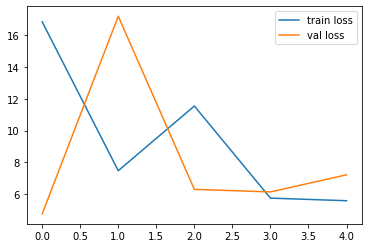

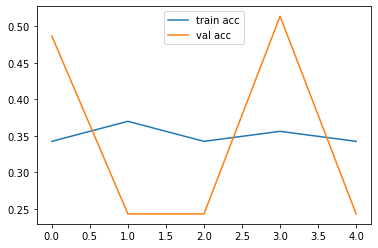

<Figure size 432x288 with 0 Axes>

In [21]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [32]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('/home/gb/PycharmProjects/Deep_Learning_Car_Brand/Datasets/model_resnet5.h5')

In [39]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [40]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

/home/gb/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /tmp/tmprmkrjo2w/assets


In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

In [38]:
# !pip freeze > "/home/gb/PycharmProjects/Deep_Learning_Car_Brand/Datasets/requirements.txt"

absl-py==0.12.0
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==2.0.1
anaconda-project==0.8.3
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///tmp/build/80754af9/argon2-cffi_1596828493937/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///tmp/build/80754af9/astroid_1592495912941/work
astropy==4.0.2
astunparse==1.6.3
async-generator==1.10
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
auto-ts==0.0.35
autopep8 @ file:///tmp/build/80754af9/autopep8_1596578164842/work
Babel @ file:///tmp/build/80754af9/babel_1605108370292/work
backcall==0.2.0
backports.functools-lru-cache==1.6.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4 @ file:///tmp/build/80754af9/beautifulsoup4_1601924105527/work
bitarray @ file:///tmp/build/80754af9/bitarray_1605065113847/work
bkcharts==0.2
bleach @ file:///tmp/build/80754af9/bleach_1600439572647/work
bokeh @ file:/

## converting the model to tflite

## loading the saved model and predicting 

In [40]:
y_pred = model.predict(test_set)

In [41]:
# y_pred

In [42]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [43]:
y_pred

array([3, 1, 2, 1, 3, 2, 3, 1, 3, 2, 3, 2, 0, 3, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 2, 3, 2, 0, 3, 2, 3, 2, 1, 2, 3, 2, 2, 0, 2, 3, 0, 2, 2,
       2, 2, 2, 3, 3, 1, 2, 0, 2, 2, 3, 3, 2, 1, 3, 2, 0, 2, 3, 1, 3, 2,
       1])

In [44]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [27]:
model=load_model('model_resnet20.h5')

In [28]:
#reading a new image 
img=image.load_img('/home/gb/PycharmProjects/Deep_Learning_Car_Brand/Datasets/test/ferrari/8.jpg',target_size=(224,224))

In [29]:
x=image.img_to_array(img)
# x

In [30]:
x.shape

(224, 224, 3)

In [31]:
x=x/255

In [33]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [34]:
model.predict(img_data)

array([[2.0250992e-03, 1.1566703e-03, 1.7054953e-02, 2.4644135e-02,
        5.7517655e-02, 2.5616603e-02, 1.6103381e-02, 2.8557545e-01,
        4.6160768e-04, 5.6984448e-01]], dtype=float32)

In [35]:
a=np.argmax(model.predict(img_data), axis=1)

In [36]:
a

array([9])

## Fine-tune pre-trained model with pruning

In [33]:
! pip install -q tensorflow-model-optimization

In [34]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras

%load_ext tensorboard



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [35]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 
training_set_number=120
num_images = training_set_number * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/home/gb/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv1_pad ( (None, 230, 230, 3)  1           input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1_conv  (None, 112, 112, 64) 18882       prune_low_magnitude_conv1_pad[0][
__________________________________________________________________________________________________
prune_low_magnitude_conv1_bn (P (None, 112, 112, 64) 257         prune_low_magnitude_conv1_conv[0]
____________________________________________________________________________________________

In [36]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]


In [1]:
model_for_pruning.fit(x=training_set, y=training_set,batch_size=batch_size, epochs=epochs,
                                                      validation_data=test_set,
                                                      callbacks=callbacks)

NameError: name 'model_for_pruning' is not defined

In [1]:
train

NameError: name 'train' is not defined

In [ ]:
# tf.keras.utils.image_dataset_from_directory(
#     directory, labels='inferred', label_mode='int',
#     class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
#     256), shuffle=True, seed=None, validation_split=None, subset=None,
#     interpolation='bilinear', follow_links=False,
#     crop_to_aspect_ratio=False, **kwargs
# )
